<a href="https://colab.research.google.com/github/geocarvalho/uni-proj/blob/master/IF699/francisco/chico_question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys, os, warnings
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import wilcoxon

---
Best K for grid_1:  3
Best K for grid_2:  1
---
WilcoxonResult(statistic=0.0, pvalue=5.886000650612085e-51)
Statistics=0.000, p=0.000
Distribuições diferentes (rejeita H0)
---
Intervalo de confiança para GaussianNB:  (0.6262734023724522, 0.7182027881037384)
Acurácia para GaussianNB:  0.6722380952380953
Intervalo de confiança para KNeighborsClassifier:  (0.8342489827368689, 0.9190208585329722)
Acurácia para KNeighborsClassifier:  0.8766349206349205
---


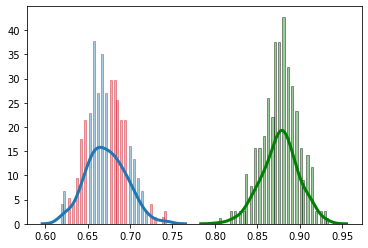

In [84]:

def mean_confidence_interval(data, confidence=0.95):
  mean = np.mean(data)
  std = np.std(data)
  conf_int = scipy.stats.norm.interval(confidence, loc=mean, scale=std)
  return conf_int


# Ler os dados Image Segmentation Database
data = pd.read_csv('https://raw.githubusercontent.com/FelipeMartins96/IN1102_AM_fatc_2019.2/master/data/seg.test')

# Abri os resultados de classe para cada amostra
ground_truth = np.genfromtxt('https://raw.githubusercontent.com/FelipeMartins96/IN1102_AM_fatc_2019.2/master/data/test_gt.csv', delimiter=',')

# Divide o dado em shape view e rgb view
# Primeiras 9 colunas
# shape_view([2100]points (n), [9]features (p))
shape_view = data.values[:, 0:9]
# Demais 10 colunas
# rgb_view([2100]points (n), [10]features (p))
rgb_view = data.values[:, 9:19]

L = 2
K = 7

prob_priori = np.zeros(K)
for i in range(0,K):
    prob_priori[i] = np.count_nonzero(ground_truth==i) / ground_truth.shape[0]

#GRID SEARCH CROSS VALIDATION - ENCONTRAR MELHOR NUMERO DE VIZINHOS
kb_1 = KNeighborsClassifier()
kb_2 = KNeighborsClassifier()


k_range = list(range(1,31))
param_grid = dict(n_neighbors=k_range)

grid_1 = GridSearchCV(kb_1, param_grid, cv=10, scoring='accuracy', n_jobs=6)
grid_2 = GridSearchCV(kb_2, param_grid, cv=10, scoring='accuracy', n_jobs=6)

grid_1.fit(shape_view, ground_truth)
grid_2.fit(rgb_view, ground_truth)

print('---')
print('Best K for grid_1: ', grid_1.best_params_['n_neighbors'])
print('Best K for grid_2: ', grid_2.best_params_['n_neighbors'])
print('---')

# Use validação cruzada estratificada '30 times ten fold' para validar e comparar
# os classificadores combinados descritos.
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30)
score_gb = []
score_kb = []

for train_index, test_index in rskf.split(shape_view, ground_truth):

    shape_train, shape_test = shape_view[train_index], shape_view[test_index]
    rgb_train, rgb_test = rgb_view[train_index], rgb_view[test_index]
    true_labels_train, true_labels_test = ground_truth[train_index], ground_truth[test_index]

    # Classificador Bayesiano Gaussiano
    gb_1 = GaussianNB()
    gb_2 = GaussianNB()

    gb_1.fit(shape_train, true_labels_train)
    gb_2.fit(rgb_train, true_labels_train)

    pred_1 = gb_1.predict_proba(shape_test)
    pred_2 = gb_2.predict_proba(rgb_test)

    # Classificador combinado pela regra da soma a partir do classificador
    # bayesiano gaussiano (um para cada view).
    gb_ensemble = np.argmax(((1-L)*(prob_priori) + pred_1 + pred_2), axis=1)

    # Score do Ensemble
    score_gb.append(np.equal(gb_ensemble, true_labels_test).sum() / true_labels_test.shape[0])

    # Classificador KNN Bayesiano
    kb_1 = KNeighborsClassifier(n_neighbors=grid_1.best_params_['n_neighbors'])
    kb_2 = KNeighborsClassifier(n_neighbors=grid_2.best_params_['n_neighbors'])

    kb_1.fit(shape_train, true_labels_train)
    kb_2.fit(rgb_train, true_labels_train)

    pred_1 = kb_1.predict_proba(shape_test)
    pred_2 = kb_2.predict_proba(rgb_test)

    # Ensemble pela regra da soma
    kb_ensemble = np.argmax(((1-L)*(prob_priori) + pred_1 + pred_2), axis=1)
    # Score dos ensembles
    score_kb.append(np.equal(kb_ensemble, true_labels_test).sum() / true_labels_test.shape[0])

# Teste Wilcoxon nos 2 classificadores acima
stat, p = wilcoxon(score_gb, score_kb)
print(wilcoxon(score_gb, score_kb))
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpretação
alpha = 0.05
if p > alpha:
  print('Mesma distribuição (falha em rejeitar H0)')
  print('---')
else:
  print('Distribuições diferentes (rejeita H0)')
  print('---')

# Intervalo de confiança
print('Intervalo de confiança para GaussianNB: ', mean_confidence_interval(score_gb))
print('Acurácia para GaussianNB: ', np.mean(score_gb))
print('Intervalo de confiança para KNeighborsClassifier: ', mean_confidence_interval(score_kb))
print('Acurácia para KNeighborsClassifier: ', np.mean(score_kb))
print('---')
    
hist_skb  = sns.distplot(score_kb, hist=True, kde=True,
    bins=int(50), color = 'green',
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 3})
fig1 = hist_skb.get_figure()

hist_sgb  = sns.distplot(score_gb, hist=True, kde=True,
    bins=int(50), hist_kws={'edgecolor':'red'},
    kde_kws={'linewidth': 3})
hist_sgb.figure.savefig('hist_sgb.png')